### Introduction to Data Science

### Computer Assignment number zero

#### Professors: Bahrak and Yaghoob Zade

#### Mohamad Mahdi Samadi & Kasra Ghorbani

This assigment is about collecting data from Etherscan.io website.

imports

In [143]:
import json
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import time
import pandas as pd

Defined numbers

In [144]:
blocks_num = 10
pages_num = 50

set the geckodriver path to the path in your OS.

In [145]:
driver = webdriver.Firefox()
driver.get("https://etherscan.io/txs")


parse the HTML of the website using beautiful soup. THis function breaks down the HTML. 

In [146]:
the_soup = BeautifulSoup(driver.page_source, 'html.parser')

reading page by page. causes a lot of problems. for example new data is stored at the top and the old data is pushed forward so during data scraping there might be duplicate data and that's why we choose to read blocks instead of pages.

The only needed data in a transaction is the value and Txn fee and the rest of them doesn't give much information to us.

the read_row function breaks the given row to smaller parts.

In [147]:
def read_row(row):
    cols = row.find_all('td')
    # these four columns are all we need for data analysing
    # Block number, Age, Value, Txn fee
    return [cols[3].text.strip(), cols[10].text.strip(), cols[11].text.strip()]

def read_pages():
    data = []
    for i in range(pages_num):
        page_path = 'https://etherscan.io/txs?p=' + str(i+1)
        driver.get(page_path)

        # Parse the HTML
        soup = BeautifulSoup(driver.page_source, 'html.parser')

        rows = soup.find_all('tr')

        for row in rows[1:]:
            # these three columns are all we need for data analysing
            data.append(read_row(row))
    return pd.DataFrame(data, columns=['Age', 'Value', 'Txn Fee'])

This function breaks down the page to its rows. Each row represent a transaction. THen using read_row function we can store the needed information from each row.

In [148]:
def parse_transaction(soup):
    rows = soup.find_all('tr')
    return [read_row(rows[i]) for i in range(1, len(rows)-1)]

This function reads the latest page and transation. This transaction belonges to a block and that would be our initial block.

In [149]:
def find_first_block(driver) -> int:
    the_soup = BeautifulSoup(driver.page_source, 'html.parser')
    trans = parse_transaction(the_soup)
    return int(trans[0][0])
print(find_first_block(driver))

19399763


This function reads an entire block. FOr each page in this block, We eill use parse_transaction function to extract the nedded data.

In [150]:
def read_block(driver, block_num):
    data = []
    driver.get('https://etherscan.io/txs?block='+str(block_num))
    the_soup = BeautifulSoup(driver.page_source, 'html.parser')
    page_count = int(the_soup.find(class_="page-link text-nowrap").text.split()[3])
    for page_number in range(1, page_count + 1):
        driver.get('https://etherscan.io/txs?block=' + str(block_num) + '&p=' + str(page_number))
        the_soup = BeautifulSoup(driver.page_source, 'html.parser')
        data.extend(parse_transaction(the_soup))
    return data

Here we call read_block function for each block.

In [151]:
def read_blocks(driver, first_block) -> list[dict]:
    data = []
    for i in range(blocks_num):
        data.extend(read_block(driver, first_block - i))
    return data

Some transactions are in wei and some are in ETH and wei is very small in comparisson to ETH. ABout half of the transactions are very close zero wei and don't give much useful information to us and makes it harder to analyse the bigger data. So we can just remove them.

In [152]:
def convert_to_eth(value):
    if 'wei' in value:
        return float(value.replace(' wei', '')) / 10**18
    else:
        return float(value.replace(' ETH', ''))

def clean_data(df):
    df['Value'] = df['Value'].apply(convert_to_eth)
    # Remove rows with less than 250 Wei
    df = df[df['Value'] > 10**6 / 10**18 * 4]
    return df



now that we have everything we need let's put them together.

In [153]:
def scrape_data():
    first_block = find_first_block(driver)
    data = read_blocks(driver, first_block)
    df = pd.DataFrame(data, columns=['Block', 'Value', 'Txn_fee'])
    df = clean_data(df)
    df.to_csv('etherscan_txns.csv', index=False)

scrape_data()
    

Data Analysis

In [154]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
from scipy.stats import norm

Loading the stored data of csv file to a DataFrame. It's easier to work with dataframes.

In [155]:
df = pd.read_csv("etherscan_txns.csv")

#### static analyze

Using numpy and pandas libraries we analyse the Value and Txn_fee columns by some asked parameters like mean, median, first and third quantiles and ...

In [156]:
median = {i: np.median(df[i]) for i in ["Value", "Txn_fee"]}
IQR = {i: np.subtract(*np.percentile(df[i], [75, 25])) for i in ["Value", "Txn_fee"]}
df_static = pd.concat([df.describe(), pd.DataFrame([median, IQR], columns=median.keys(), index=["median", "IQR"])])[["Value", "Txn_fee"]].style.set_caption("")
df_static

,Value,Txn_fee
count,856.000000,856.000000
mean,1.522581,0.006993
std,23.370429,0.034128
min,0.000000,0.001403
25%,0.017974,0.001491
50%,0.076937,0.001713
75%,0.298125,0.008599
max,668.000000,0.833654
median,0.076937,0.001713
IQR,0.280151,0.007109


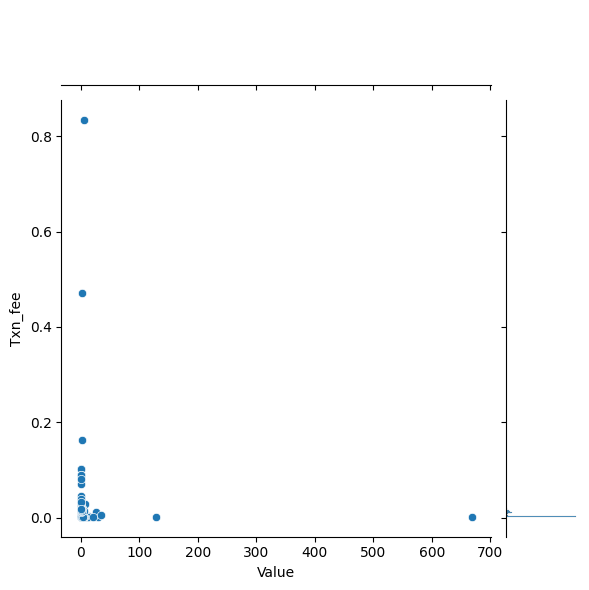

In [157]:
sns.jointplot(x="Value", y="Txn_fee", data=df, kind="scatter")

The graph is a scatter plot that visualizes the relationship between two variables: Value and Tnx Fee. The x-axis represents the Value, which could be the amount of Ether (ETH) being transferred in a transaction, and the y-axis represents the tnx fee
Most data points are clustered near the origin, indicating that a large number of transactions involve small values and incur low fees.

<Axes: xlabel='Txn_fee'>

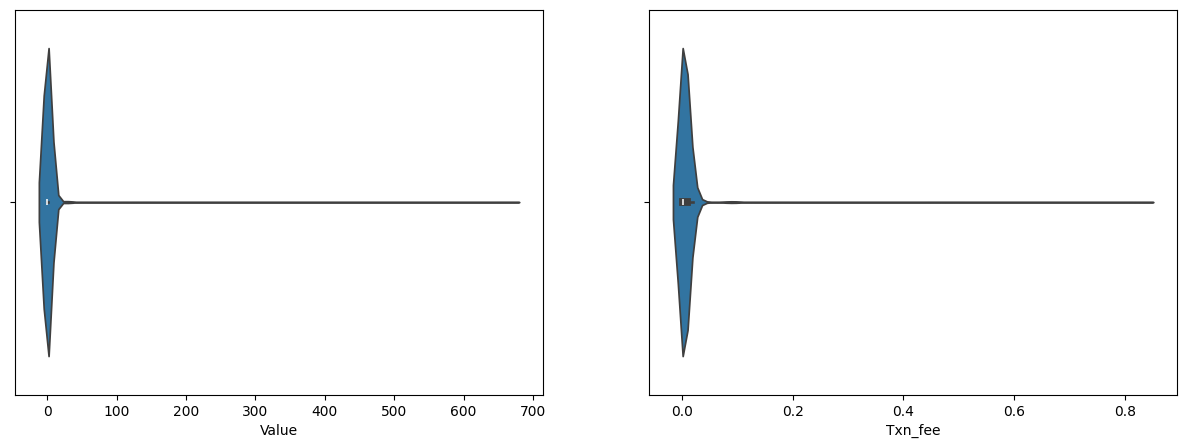

In [158]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.violinplot(x=df["Value"], ax=axes[0])
sns.violinplot(x=df["Txn_fee"], ax=axes[1])

Value Distribution: The concentration of data points near zero in the Value plot suggests that most transactions involve a small amount of Ether, indicating that everyday, low-value transactions are common on the network.

Transaction Fee Trends: Similarly, the Txn_fee plot shows that most transaction fees are low, with a few outliers indicating occasional transactions with higher fees. This could reflect the varying complexity of transactions or changes in network congestion at different times.

Box Plot

<Axes: >

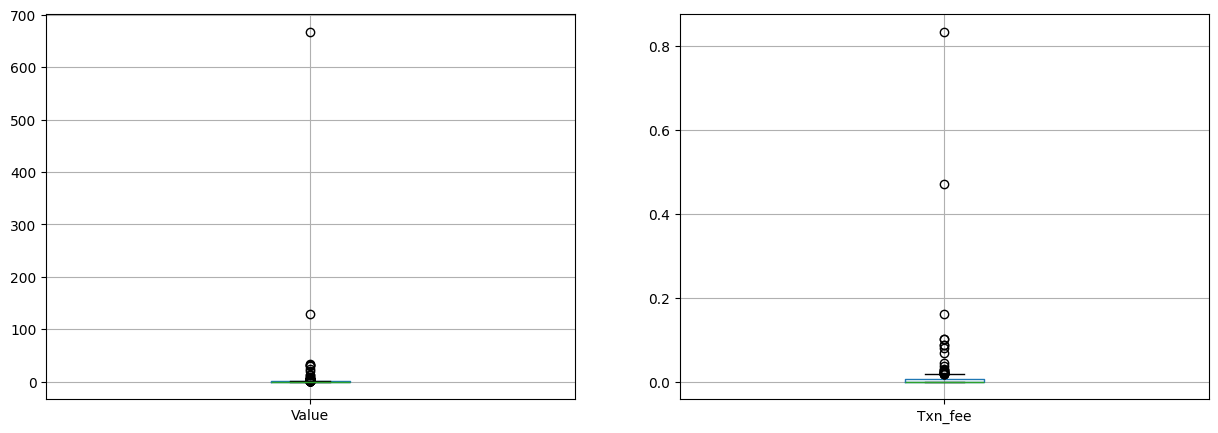

In [159]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
pd.DataFrame(df['Value']).boxplot(ax=axes[0])
pd.DataFrame(df['Txn_fee']).boxplot(ax=axes[1])

Taking the logarithm of Value and Txn_fee columns to make the graphs easier to analyse.

In [160]:
import math
df_log = df.copy(deep=True)
df_log['Value'] = df['Value'].apply(
    lambda val: math.log2(val) if val != 0 else math.log2(10 ** -25))
df_log['Txn_fee'] = df['Txn_fee'].apply(
    lambda val: math.log2(val))

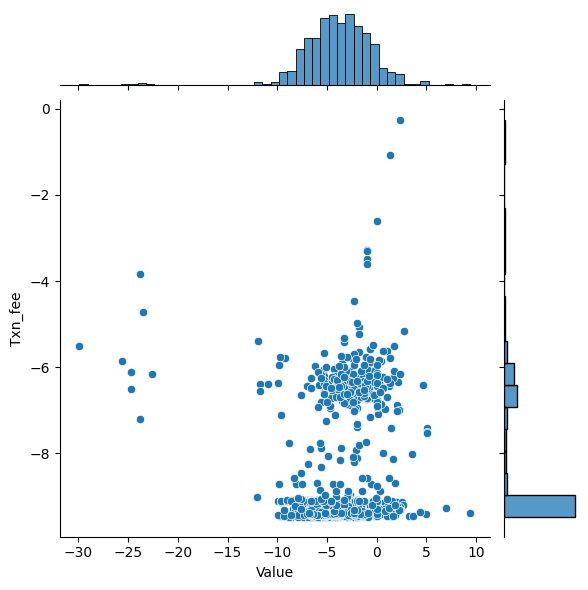

In [161]:
sns.jointplot(x="Value", y="Txn_fee", data=df_log, kind="scatter")

<Axes: xlabel='Txn_fee'>

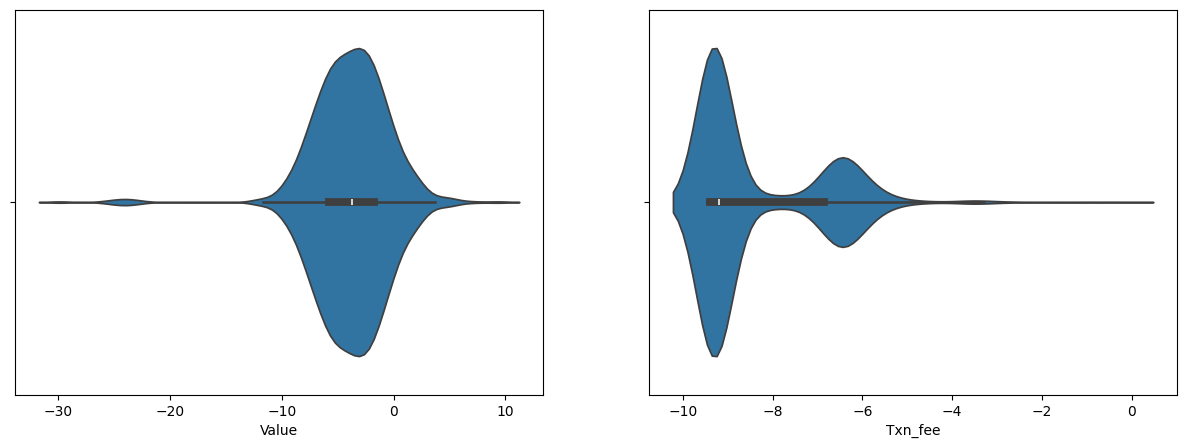

In [162]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.violinplot(x=df_log["Value"], ax=axes[0])
sns.violinplot(x=df_log["Txn_fee"], ax=axes[1])

Box Plot

<Axes: >

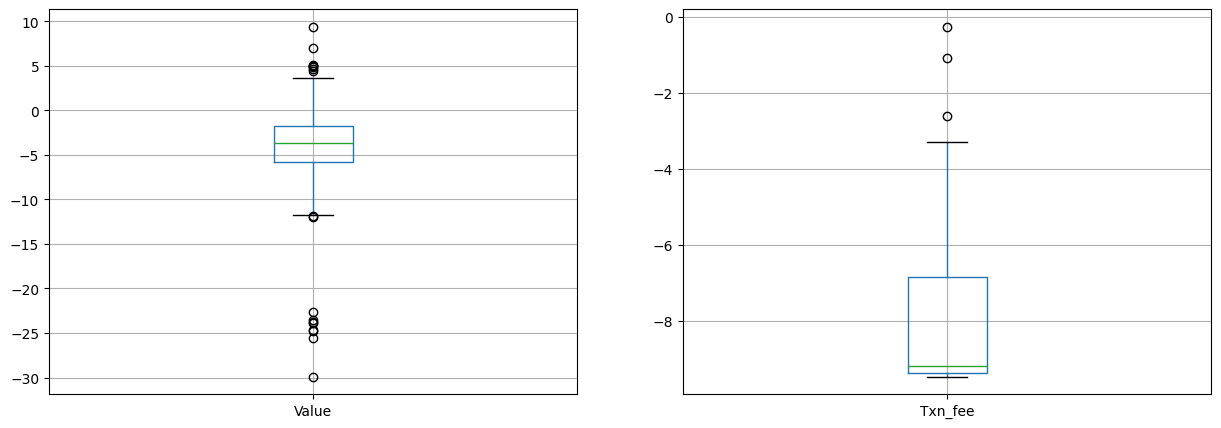

In [163]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
pd.DataFrame(df_log['Value']).boxplot(ax=axes[0])
pd.DataFrame(df_log['Txn_fee']).boxplot(ax=axes[1])

In [164]:
import math
import statistics
from scipy.stats import iqr

In [165]:
df[["Value","Txn_fee"]].describe()

,Value,Txn_fee
count,8.560000e+02,856.000000
mean,1.522581e+00,0.006993
std,2.337043e+01,0.034128
min,1.000000e-09,0.001403
25%,1.797405e-02,0.001491
50%,7.693741e-02,0.001713
75%,2.981250e-01,0.008599
max,6.680000e+02,0.833654


random sampling

In [166]:
random_sample = df.sample(n=round((5/100)*len(df)))
random_sample[["Value","Txn_fee"]].describe()

,Value,Txn_fee
count,4.300000e+01,43.000000
mean,1.189343e-01,0.004283
std,1.712502e-01,0.004888
min,3.700000e-08,0.001403
25%,1.370820e-02,0.001471
50%,4.875849e-02,0.001667
75%,1.566333e-01,0.005801
max,8.000000e-01,0.019586


TxHash: A unique identifier for the transaction, also known as the transaction hash.

Block: The block number in which the transaction was included.

Age: The time elapsed since the transaction was included in a block.

From: The address that initiated the transaction.

To: The recipient address of the transaction. If it’s a contract creation, this field may be blank.

Value: The amount of Ether transferred in the transaction.

TxnFee: The fee paid for the transaction, calculated as Gas Used by Transaction * Gas Price.

Gas Limit: The maximum amount of gas that the transaction can consume.

Gas Used by Transaction: The actual amount of gas used by the transaction.

Gas Price: The price per unit of gas, typically denoted in Gwei.

Nonce: A sequential number assigned by the sender to each transaction to prevent double-spending.

Input Data: Additional data sent with the transaction, often used for contract interactions.

### **Questions**

There are some questions at the end of the assignment description.

1) The structure of the web page changing over time can be a challenge. We did not face this particular problem but it’s a very common problem and we need to update the code each time so that we can successfully scrap the data if this ever happens. The collected data contain a lot of unnecessary and useless info which we need to clean first and then get to the analysis. In our case it was the hash functions. The users the time stamps and low value transactions. Ip blocking when we send to many requests in a short period of time. Captcha and identification.

2) When we tried to read pages instead of blocks at first we were reading repetitive data which is incorrect and a biased form of analysis. Also inclusion of unrelated data which in this case would be low or 0 value transactions can greatly alter the results of the analysis. Using a sample which is too small also makes our analysis untrustworthy. In our case 10 blocks of transactions has well over 2000 transactions wich is a fair amount.

3) The visualisation of the data helps with identifying the distribution of the transaction values and the tnx fees. They also help with spotting points of interest (trends). They also help us to better understand the relationships between different parameters and if any variables share the same distribution or at the very least have a connection.